# Analyze Order Book Data

## Imports & Settings

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show
from scipy.stats import normaltest

In [3]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

In [4]:
data_path = Path('D:\ML4T\C1数据') 
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20191030'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

## Load system event data

In [5]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Trade Summary

We will combine the messages that refer to actual trades to learn about the volumes for each asset.

In [6]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8887 entries, 0 to 8886
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   stock_locate                    8887 non-null   int64          
 1   tracking_number                 8887 non-null   int64          
 2   timestamp                       8887 non-null   timedelta64[ns]
 3   stock                           8887 non-null   object         
 4   market_category                 8887 non-null   object         
 5   financial_status_indicator      8887 non-null   object         
 6   round_lot_size                  8887 non-null   int64          
 7   round_lots_only                 8887 non-null   object         
 8   issue_classification            8887 non-null   object         
 9   issue_sub_type                  8887 non-null   object         
 10  authenticity                    8887 non-null   object         
 

As expected, a small number of the over 8,500 equity securities traded on this day account for most trades

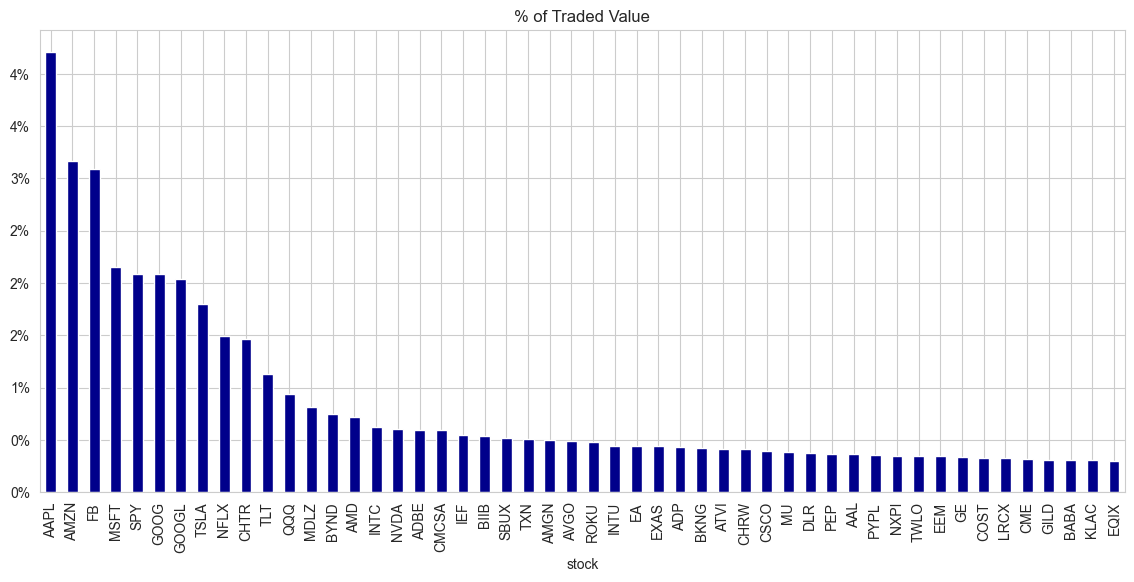

In [8]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    #trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)
    trades = pd.concat([store['P'], store['Q'].rename(columns={'cross_price': 'price'})], ignore_index=True, sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## AAPL Trade Summary

In [9]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

In [10]:
trades.price = trades.price.mul(1e-4) # format price
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58713 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 15:59:59.979015439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   shares  58713 non-null  int32  
 1   price   58713 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 1.1 MB


## Tick Bars

The trade data is indexed by nanoseconds and is very noisy. The bid-ask bounce, for instance, causes the price to oscillate between the bid and ask prices when trade initiation alternates between buy and sell market orders. To improve the noise-signal ratio and improve the statistical properties, we need to resample and regularize the tick data by aggregating the trading activity.

We typically collect the open (first), low, high, and closing (last) price for the aggregated period, alongside the volume-weighted average price (VWAP), the number of shares traded, and the timestamp associated with the data.

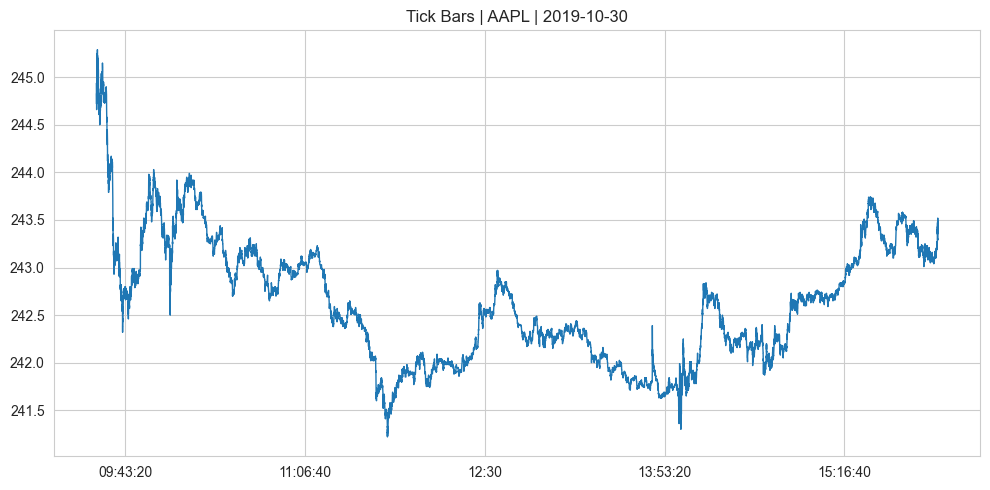

In [11]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(10, 5), 
                     title='Tick Bars | {} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

### Test for Normality of tick returns

In [12]:
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=20684.40456159484, pvalue=0.0)

## Regularizing Tick Data

### Price-Volume Chart

We will use the `price_volume` function to compare the price-volume relation for various regularization methods.

In [34]:
def price_volume(df, price='vwap', vol='vol', suptitle=title, fname=None):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index.to_numpy(), df[price].to_numpy())
    axes[1].bar(df.index.to_numpy(), df[vol].to_numpy(), width=1/(5*len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9);

### Time Bars

Time bars involve trade aggregation by period.

In [35]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

We create time bars using the `.resample()` method with the desired period.

In [36]:
resampled = trades.groupby(pd.Grouper(freq='1Min'))
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

NormaltestResult(statistic=65.70387182967823, pvalue=5.402384769537968e-15)

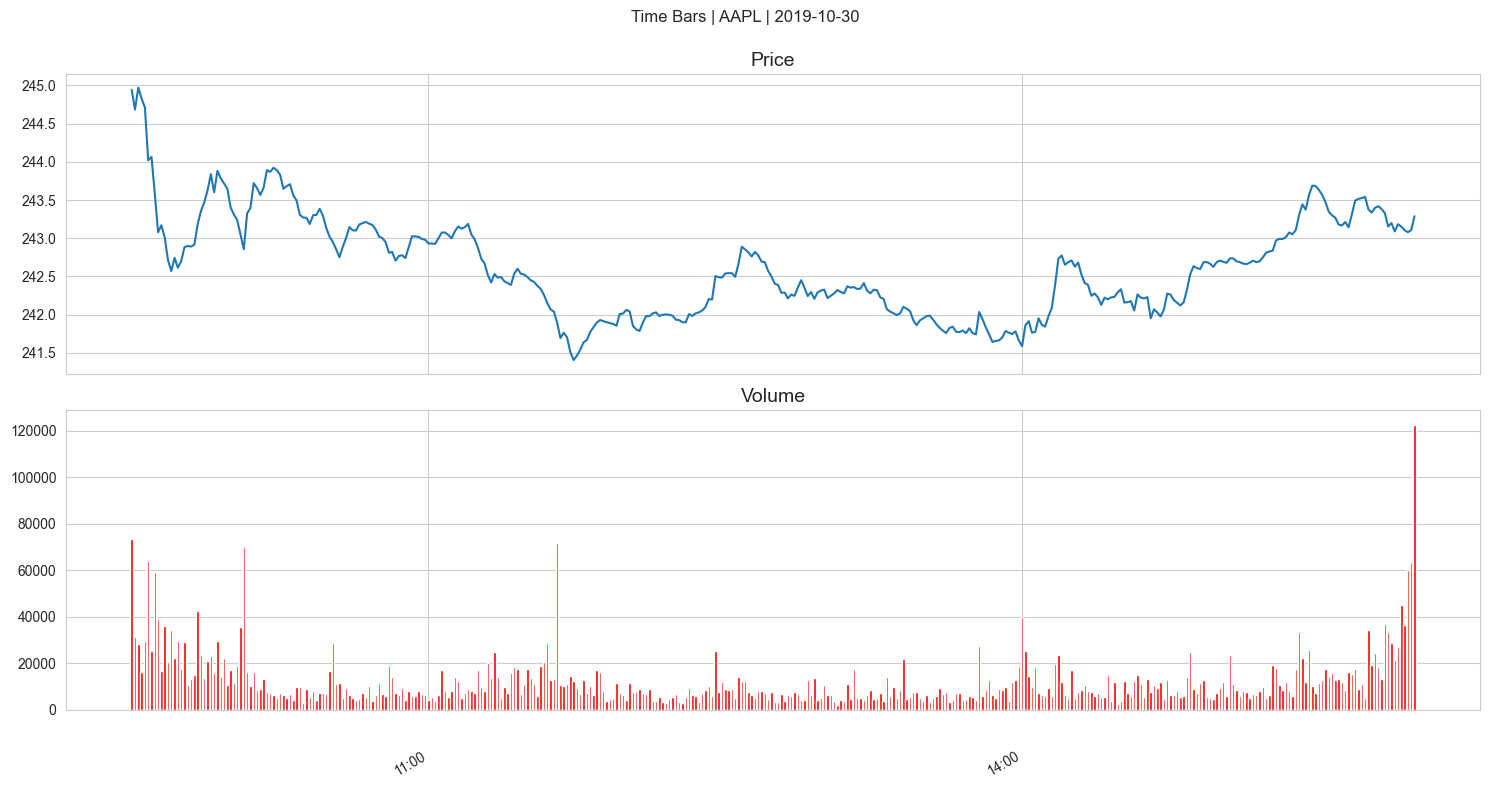

In [37]:
price_volume(time_bars, 
             suptitle=f'Time Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='time_bars')

In [38]:
time_bars.index.to_numpy().shape

(390,)

In [39]:
time_bars

,open,high,low,close,vwap,vol,txn
timestamp,,,,,,,
2019-10-30 09:30:00,244.83,245.29,244.66,244.84,244.94,73526,712
2019-10-30 09:31:00,244.81,244.81,244.50,244.77,244.68,31167,361
2019-10-30 09:32:00,244.74,245.15,244.70,244.90,244.97,28473,414
2019-10-30 09:33:00,244.93,244.95,244.73,244.74,244.83,16243,262
2019-10-30 09:34:00,244.78,244.90,244.37,244.45,244.71,29686,265
...,...,...,...,...,...,...,...
2019-10-30 15:55:00,243.19,243.23,243.08,243.13,243.15,44951,423
2019-10-30 15:56:00,243.12,243.17,243.05,243.08,243.11,36502,395
2019-10-30 15:57:00,243.08,243.16,243.05,243.06,243.08,59923,564


### Bokeh Candlestick Chart

Alternative visualization using the the [bokeh](https://bokeh.pydata.org/en/latest/) library:

In [41]:
resampled = trades.groupby(pd.Grouper(freq='5Min')) # 5 Min bars for better print
df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms

WIDGETS = "pan, wheel_zoom, box_zoom, reset, save"

p = figure(x_axis_type='datetime', tools=WIDGETS, width=1500, title = "AAPL Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color="black")
p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color="#F2583E", line_color="black")
show(p)

### Volume Bars

Time bars smooth some of the noise contained in the raw tick data but may fail to account for the fragmentation of orders. Execution-focused algorithmic trading may aim to match the volume weighted average price (VWAP) over a given period, and will divide a single order into multiple trades and place orders according to historical patterns. Time bars would treat the same order differently, even though no new information has arrived in the market.

Volume bars offer an alternative by aggregating trade data according to volume. We can accomplish this as follows:

In [42]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58713 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 15:59:59.979015439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   shares  58713 non-null  int32  
 1   price   58713 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 1.1 MB


In [43]:
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()

In [44]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2019-10-30 09:30:01.658183871,244.83,244.94,244.72,244.82,244.77,5317,57
1,2019-10-30 09:30:02.124784227,244.82,244.85,244.76,244.77,244.79,9127,44
2,2019-10-30 09:30:04.690393971,244.77,244.97,244.66,244.97,244.80,12257,76
3,2019-10-30 09:30:13.816494419,244.98,245.00,244.88,245.00,244.98,10675,124
4,2019-10-30 09:30:17.522394656,245.00,245.25,245.00,245.10,245.10,10679,118


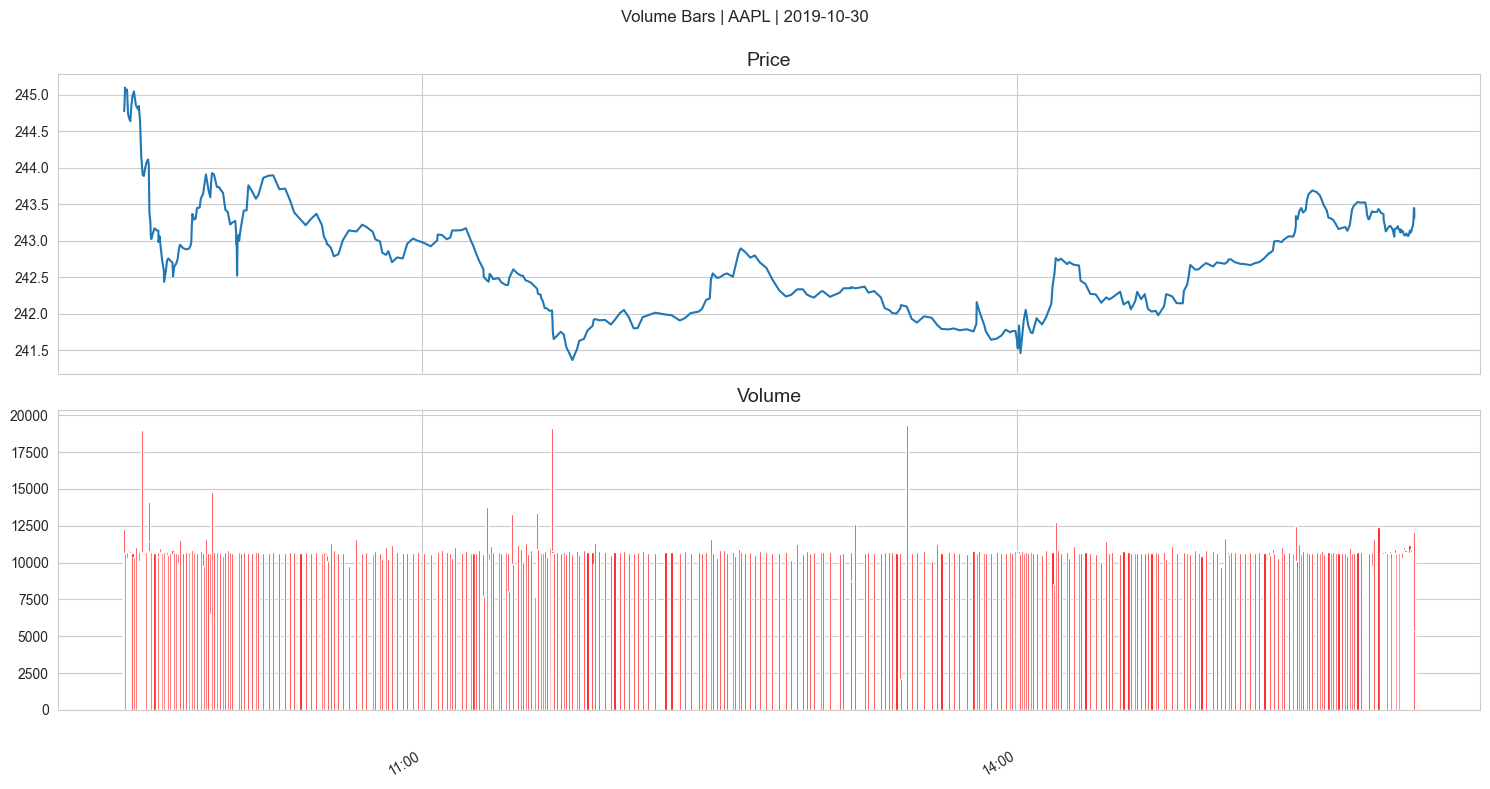

In [45]:
price_volume(vol_bars.set_index('timestamp'), 
             suptitle=f'Volume Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='volume_bars')

In [46]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=26.54669921949387, pvalue=1.7197190736584466e-06)

### Dollar Bars

In [47]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58713 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 15:59:59.979015439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   shares  58713 non-null  int32  
 1   price   58713 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 1.1 MB


In [48]:
value_per_min = trades.shares.mul(trades.price).sum()/(60*7.5) # min per trading day
trades['cumul_val'] = trades.shares.mul(trades.price).cumsum()

In [49]:
df = trades.reset_index()
by_value = df.groupby(df.cumul_val.div(value_per_min).round().astype(int))
dollar_bars = pd.concat([by_value.timestamp.last().to_frame('timestamp'), get_bar_stats(by_value)], axis=1)
dollar_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_val,,,,,,,,
0,2019-10-30 09:30:01.658171058,244.83,244.94,244.72,244.82,244.77,5287,56
1,2019-10-30 09:30:02.124784227,244.82,244.85,244.76,244.77,244.79,9157,45
2,2019-10-30 09:30:04.095544194,244.77,244.96,244.66,244.87,244.80,12047,71
3,2019-10-30 09:30:13.816494419,244.87,245.00,244.87,245.00,244.98,10474,127
4,2019-10-30 09:30:17.522098123,245.00,245.25,245.00,245.13,245.09,10690,116


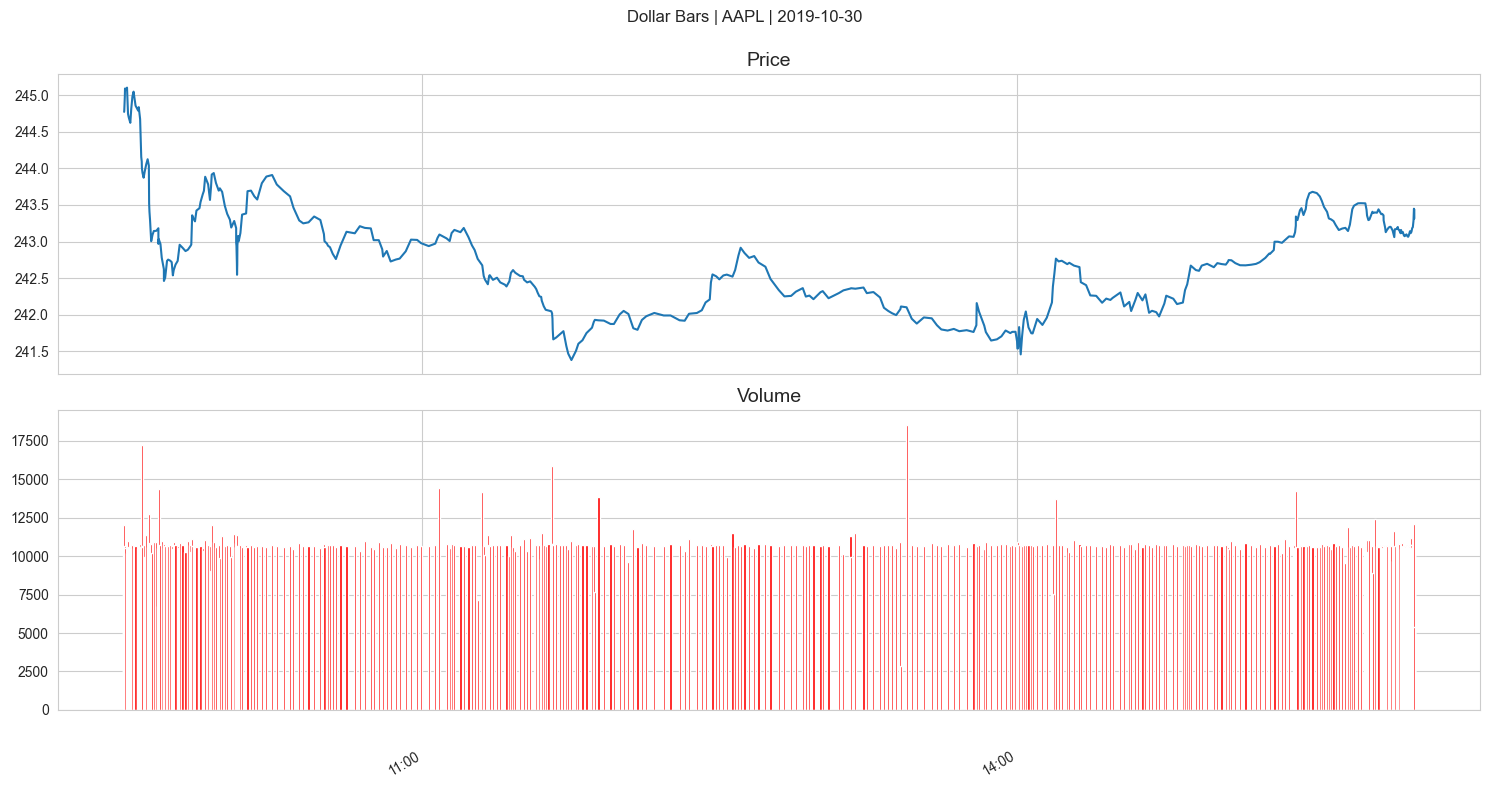

In [50]:
price_volume(dollar_bars.set_index('timestamp'), 
             suptitle=f'Dollar Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='dollar_bars')